# Forecast

For practical implementation:
https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

For theoretical knowledge of spline:
https://timodenk.com/blog/cubic-spline-interpolation/


In [1]:
# Author: Mathieu Blondel
#         Jake Vanderplas
#         Christian Lorentzen
#         Malte Londschien
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
import os
import matplotlib.lines as mlines
import seaborn as sns
from distfit import distfit

In [2]:

desktop = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop') 
#print(os.getcwd())
This_file_path = os.getcwd()
total_string_len = len(This_file_path)
#print(total_string_len)

string_len_to_remove = len("Data Examination")
#print(string_len_to_remove)

path = This_file_path[0:(total_string_len-string_len_to_remove)]
#print(path)
path_processed_data = path + "Processed_data\\"
#print(path_processed_data)

# Set up FCR-D forecast. Mean for the past 5 days. Base case
- At D-2 it is past 5 days, meaning 7 days from what to predict.
- At D-1 it is the past 5 days, meaning 6 days from what to predict

In [3]:
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
data = data.drop(columns=["Hour"])
True_data = data
True_data_arr = True_data.to_numpy()


In [86]:
Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_up","FD_act_down"]
Total_length_test = len(data["FD1_down"])
forecasted_data = np.zeros(( Total_length_test, len(Forecasts) ))  # (Specific Forecasts, Data size, number of total forecasts )
print(np.shape(forecasted_data))

(10920, 11)


In [87]:
index_FD1_up_percentage = Forecasts.index("FD1_up_percentage")
index_FD1_down_percentage = Forecasts.index("FD1_down_percentage")

D_2_list = [2,3,4,5,6]
start_idx = D_2_list[-1]*24

for col in data.columns:
    index = Forecasts.index(col) # Get the index
    
    # Run mean procedure

    # As the volumes need to add up to 100% then is it only the D-1 which has been forecasted as t
    if 'percentage' in col:
            if "FD2" in col:
                if "up" in col:
                    forecasted_data[:,index] = 1 - forecasted_data[:,index_FD1_up_percentage]
                else:
                    forecasted_data[:,index] = 1 - forecasted_data[:,index_FD1_down_percentage]
                    #forecasted_data.loc[h, col] = 1 - forecasted_data.loc[h, 'FD1_down_percentage']
            else:
                for h in range(start_idx,Total_length_test):
                    value = 0
                    for hd in D_2_list:

                        #print(data.loc[h+8760-hd*24, col])
                        #print(h+8760-hd*24)
                        value = value + data.loc[h-hd*24, col]
                    
                    forecasted_data[h,index] = value/len(D_2_list)

    else:

        for h in range(start_idx,Total_length_test):
            value = 0
            for hd in D_2_list:

                #print(data.loc[h+8760-hd*24, col])
                #print(h+8760-hd*24)
                value = value + data.loc[h-hd*24, col]
            
            forecasted_data[h,index] = value/len(D_2_list)


    print("Forecasts for ", col, " ended")

            
    

Forecasts for  Spot  ended
Forecasts for  FD1_down  ended
Forecasts for  FD2_down  ended
Forecasts for  FD1_up  ended
Forecasts for  FD2_up  ended
Forecasts for  FD1_up_percentage  ended
Forecasts for  FD2_up_percentage  ended
Forecasts for  FD1_down_percentage  ended
Forecasts for  FD2_down_percentage  ended
Forecasts for  FD_act_up  ended
Forecasts for  FD_act_down  ended


In [88]:
F_len = np.size(forecasted_data[:,:],1) # Number of features
T_len = np.size(forecasted_data[:,:],0) # length of test data
percentages = [0.7,0.75,0.8,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,1,1.05,1.1,1.15,1.2,1.25,1.3]
Saved_Info = np.zeros((F_len ,(1+1+1+2) ,len(percentages)) ) # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std) 
F = data.columns
for p in range(0,len(percentages)):
    for f in range(0,F_len): # For each type of forecast, spot, FD2 Down so forth..

        errors = (True_data_arr[:,f] - forecasted_data[:,f]*percentages[p])

        MAE_h  =np.abs(errors)
        #MAPE_h = np.abs( (errors) / (True_data_arr[:,f]) ) * 100
        
        #MAPE = np.mean(MAPE_h)
        MAE = np.mean(MAE_h)
        ME = np.median(errors)

        # Seperate into negative and positive
        # Not accepted
        negative_values = errors[errors < 0]
        ME_neg = np.mean(np.abs(negative_values))

        positive_values = errors[errors >= 0]
        ME_pos = np.mean(positive_values)


        accepted = (len(positive_values))/len(errors) *100

        #Median_APE = np.median(MAPE_h)
        Median_AE = np.median(MAE_h)
        Median_E = np.median(errors)

        #Std_APE = np.std(MAPE_h)
        Std_AE = np.std(MAE_h)
        Std_E_neg = np.std(negative_values)
        Std_E_pos = np.std(positive_values)
            
        
        Saved_Info[f,1,p] = accepted
        Saved_Info[f,2,p] = ME_pos
        Saved_Info[f,3,p] = ME_neg
        
        MAE = np.mean(MAE_h)
        

    print("Forecast ",p," ",F[0],"(",np.round(Saved_Info[0,1,p]), np.round(Saved_Info[0,2,p]), np.round(Saved_Info[0,3,p]),")", "   ",F[1],"(",np.round(Saved_Info[1,1,p]), np.round(Saved_Info[1,2,p]), np.round(Saved_Info[1,3,p]),")", "   ",F[2],"(",np.round(Saved_Info[2,1,p]), np.round(Saved_Info[2,2,p]), np.round(Saved_Info[2,3,p]),")", "   ",F[3],"(",np.round(Saved_Info[3,1,p]), np.round(Saved_Info[3,2,p]), np.round(Saved_Info[3,3,p]),")", "   ",F[4],"(",np.round(Saved_Info[4,1,p]), np.round(Saved_Info[4,2,p]), np.round(Saved_Info[4,3,p]),")")



Forecast  0   Spot ( 72.0 104.0 62.0 )     FD1_down ( 65.0 33.0 22.0 )     FD2_down ( 92.0 9.0 3.0 )     FD1_up ( 69.0 32.0 20.0 )     FD2_up ( 100.0 17.0 2.0 )
Forecast  1   Spot ( 69.0 98.0 66.0 )     FD1_down ( 59.0 34.0 22.0 )     FD2_down ( 86.0 8.0 3.0 )     FD1_up ( 65.0 31.0 20.0 )     FD2_up ( 99.0 14.0 4.0 )
Forecast  2   Spot ( 66.0 93.0 70.0 )     FD1_down ( 54.0 36.0 23.0 )     FD2_down ( 78.0 8.0 3.0 )     FD1_up ( 61.0 31.0 21.0 )     FD2_up ( 97.0 12.0 4.0 )
Forecast  3   Spot ( 64.0 88.0 73.0 )     FD1_down ( 49.0 38.0 23.0 )     FD2_down ( 69.0 8.0 4.0 )     FD1_up ( 58.0 31.0 22.0 )     FD2_up ( 92.0 10.0 4.0 )
Forecast  4   Spot ( 63.0 87.0 74.0 )     FD1_down ( 48.0 38.0 23.0 )     FD2_down ( 67.0 8.0 4.0 )     FD1_up ( 57.0 30.0 22.0 )     FD2_up ( 90.0 9.0 4.0 )
Forecast  5   Spot ( 62.0 86.0 75.0 )     FD1_down ( 47.0 39.0 23.0 )     FD2_down ( 65.0 8.0 4.0 )     FD1_up ( 56.0 30.0 23.0 )     FD2_up ( 88.0 9.0 4.0 )
Forecast  6   Spot ( 62.0 85.0 75.0 )     FD1_

## Plot the percentage add-on to the forecast

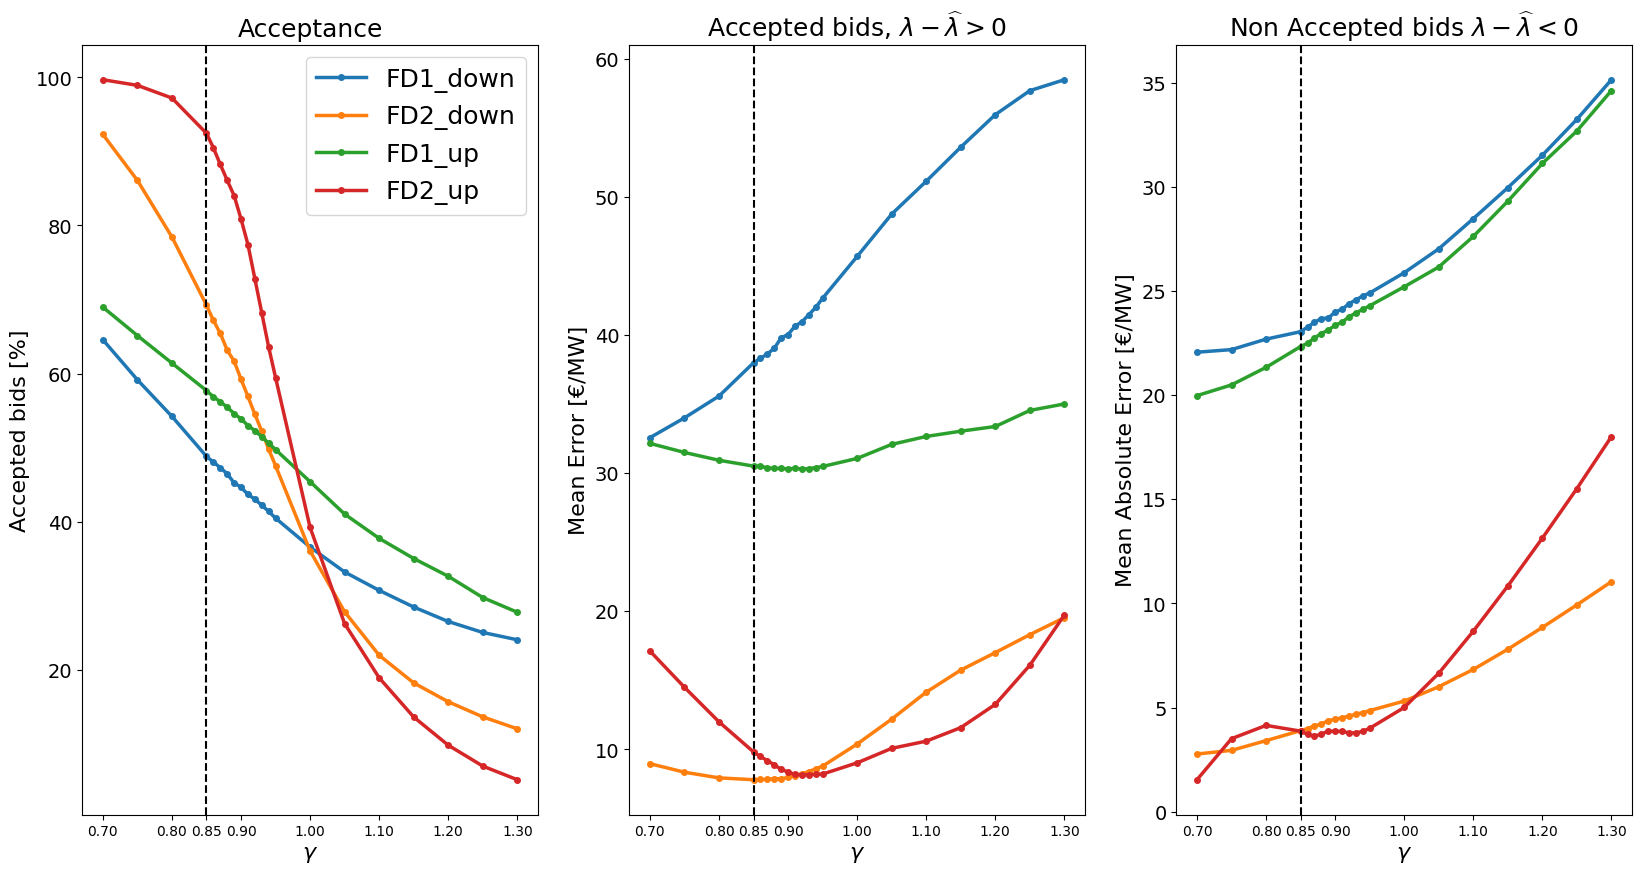

In [90]:
import matplotlib.pyplot as plt
import numpy as np

x = percentages

Forecasts = ["FD1_down", "FD2_down", "FD1_up", "FD2_up"]
linewidth = 2.5
marker_size = 8 # Adjust the marker size as desired
ME_neg_pos = [1, 2,3]
y_labels = ['Accepted bids [%]','Mean Error [€/MW]','Mean Absolute Error [€/MW]']
titles = ['Acceptance','Accepted bids, $\lambda - \widehat{\lambda} > 0$','Non Accepted bids $\lambda - \widehat{\lambda} < 0$']
fig, axs = plt.subplots(1, 3, figsize=(20, 10))  # Create subplots

# Plot for each feature on respective subplots
for i, e in enumerate(ME_neg_pos):
    ax = axs[i]  # Select the current subplot
    for f in range(len(Forecasts)):
        E = Saved_Info[f+1, e,:]
        ax.plot(x, E, linestyle='-',marker = '.', label=Forecasts[f], linewidth=linewidth, markersize=marker_size)

    ax.set_ylabel(y_labels[i], fontsize=16)
    
    ax.tick_params(axis='y', which='major', labelsize=14)

    ax.set_xlabel('$\gamma$ ', fontsize=16)  # Set x-label for the last subplot
        
    # Set xticks and labels for the current subplot
    ax.set_xticks([0.7,0.8,0.85,0.9,1,1.1,1.2,1.3])  # Set the xticks locations
    #ax.set_xticklabels([0,3,6,9,12,15,18,21,24,27,30,33,36,40], fontsize=12)  # Set the xtick labels
    ax.set_title(titles[i],fontsize=18)  # Set the title of the subplot
    
axs[0].axvline(x=0.85, ymin=0, ymax=80, color='black', linestyle='--')  # Add vertical line at x=5
axs[1].axvline(x=0.85, ymin=0, ymax=80, color='black', linestyle='--')  # Add vertical line at x=5
axs[2].axvline(x=0.85, ymin=0, ymax=80, color='black', linestyle='--')  # Add vertical line at x=5
axs[0].legend(loc='upper right', prop={'size': 18})  # Locate the legend to the middle in the right part of the plot

plt.savefig('forecast_mean_D.pdf', format="pdf", bbox_inches="tight")
plt.show()


# Create a csv file for forecasted values

In [67]:
F = data.columns
# change forecasted_data_3D to a dataframe
df_forecast = pd.DataFrame(forecasted_data[:,:], columns=F)

#Create csv
csv_name_path = path_processed_data+"forecast_all1.csv"
df_forecast.to_csv(csv_name_path,index=False)

# Create the perfect forecast as well:
csv_name_path = path_processed_data+"forecast_all0.csv"

data.to_csv(csv_name_path,index=False)

# Set up all the other forecasts

In [92]:
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
data = data.drop(columns=["Hour"])
True_data = data
True_data_arr = True_data.to_numpy()
Total_length_test = len(data["FD1_down"])


In [93]:
Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_up","FD_act_down"]
Total_length_test = len(data["FD1_down"])
forecasted_data = np.zeros(( Total_length_test, len(Forecasts) ))  # (Specific Forecasts, Data size, number of total forecasts )
print(np.shape(forecasted_data))

(10920, 11)


## Set up base case * 0.85

In [94]:
index_FD1_up_percentage = Forecasts.index("FD1_up_percentage")
index_FD1_down_percentage = Forecasts.index("FD1_down_percentage")
gamma = 0.85
D_2_list = [2,3,4,5,6]
start_idx = D_2_list[-1]*24

for col in data.columns:
    index = Forecasts.index(col) # Get the index
    
    # Run mean procedure

    # As the volumes need to add up to 100% then is it only the D-1 which has been forecasted as t
    if 'percentage' in col:
            if "FD2" in col:
                if "up" in col:
                    forecasted_data[:,index] = 1 - forecasted_data[:,index_FD1_up_percentage]
                else:
                    forecasted_data[:,index] = 1 - forecasted_data[:,index_FD1_down_percentage]
                    #forecasted_data.loc[h, col] = 1 - forecasted_data.loc[h, 'FD1_down_percentage']
            else:
                for h in range(start_idx,Total_length_test):
                    value = 0
                    for hd in D_2_list:

                        #print(data.loc[h+8760-hd*24, col])
                        #print(h+8760-hd*24)
                        value = value + data.loc[h-hd*24, col]
                    
                    forecasted_data[h,index] = value/len(D_2_list)

    else:
        for h in range(start_idx,Total_length_test):
            value = 0
            for hd in D_2_list:

                #print(data.loc[h+8760-hd*24, col])
                #print(h+8760-hd*24)
                value = value + data.loc[h-hd*24, col]

            if "FD2" in col:
                forecasted_data[h,index] = gamma*value/len(D_2_list)
            elif "FD1" in col:
                forecasted_data[h,index] = gamma*value/len(D_2_list)
            else:
                forecasted_data[h,index] = value/len(D_2_list)


    print("Forecasts for ", col, " ended")

            
    

Forecasts for  Spot  ended
Forecasts for  FD1_down  ended
Forecasts for  FD2_down  ended
Forecasts for  FD1_up  ended
Forecasts for  FD2_up  ended
Forecasts for  FD1_up_percentage  ended
Forecasts for  FD2_up_percentage  ended
Forecasts for  FD1_down_percentage  ended
Forecasts for  FD2_down_percentage  ended
Forecasts for  FD_act_up  ended
Forecasts for  FD_act_down  ended


In [95]:
F = data.columns
# change forecasted_data_3D to a dataframe
df_forecast = pd.DataFrame(forecasted_data[:,:], columns=F)

#Create csv

csv_name_path = path_processed_data+"forecast_all2.csv"
print(csv_name_path)
df_forecast.to_csv(csv_name_path,index=False)

c:\Users\Daniel  BV\Desktop\Thesis\lightenup\Processed_data\forecast_all3.csv


# Non-linear Feature transformation

In [5]:
from sklearn.preprocessing import PolynomialFeatures
transformer = PolynomialFeatures(degree=2, include_bias=False)
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
cols = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_down","FD_act_up"]
Chosen_cols = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_down","FD_act_up","Spot^2","Spot FD1_down","Spot FD2_down","Spot FD1_up","Spot FD2_up","FD1_down^2","FD1_down FD2_down","FD1_down FD1_up","FD1_down FD2_up","FD2_down^2","FD2_down FD1_up","FD2_down FD2_up","FD1_up^2","FD1_up FD2_up","FD2_up^2"]
# Assuming Chosen_cols is your list
modified_cols = [col.replace(" ", "_") for col in Chosen_cols]


transformed_data = transformer.fit_transform(data[cols])
transformed_cols = transformer.get_feature_names_out(cols).tolist() # Output it as a list and not numpy array
transformed_modified_cols = [col.replace(" ", "_") for col in transformed_cols]
transformed_df = pd.DataFrame(transformed_data, columns=transformed_modified_cols)
transformed_df[modified_cols].to_csv(path_processed_data + "features.csv", sep=',', header=True, index_label='Hour')

print(transformed_df)

            Spot  FD1_down  FD2_down    FD1_up    FD2_up  FD1_up_percentage   
0      46.599998  42.42105  33.89313   1.95478  49.18715           0.034299  \
1      41.330002  42.42105  33.89313   1.95492  49.33709           0.012891   
2      42.180000  43.36842  33.89313   1.96262  49.71026           0.013107   
3      44.369999  42.42105  33.89313   1.96222  49.45940           0.013804   
4      37.669998  41.78947  33.89313   1.95644  49.52272           0.009886   
...          ...       ...       ...       ...       ...                ...   
10915  92.500000   9.40653  18.32412  27.71766  30.13228           0.179322   
10916  48.080002   8.94430  18.28115  27.30695  29.82065           0.177119   
10917  40.930000   9.03942  18.33040  27.34312  29.82881           0.143390   
10918  35.849998   8.99331  18.35501  27.38835  29.55485           0.136610   
10919  30.040001   8.95851  18.37732  27.26135  29.58701           0.146441   

       FD2_up_percentage  FD1_down_percentage  FD2_

In [4]:
from sklearn.preprocessing import PolynomialFeatures
data = pd.read_csv(path_processed_data + 'forecast_all2.csv') # Change path
transformer = PolynomialFeatures(degree=2, include_bias=False)
cols = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_down","FD_act_up"]
Chosen_cols = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_down","FD_act_up","Spot^2","Spot FD1_down","Spot FD2_down","Spot FD1_up","Spot FD2_up","FD1_down^2","FD1_down FD2_down","FD1_down FD1_up","FD1_down FD2_up","FD2_down^2","FD2_down FD1_up","FD2_down FD2_up","FD1_up^2","FD1_up FD2_up","FD2_up^2"]
# Assuming Chosen_cols is your list
modified_cols = [col.replace(" ", "_") for col in Chosen_cols]

transformed_data = transformer.fit_transform(data[cols])
#transformed_data = transformed_data.drop(columns=["Hour"])
transformed_cols = transformer.get_feature_names_out(cols).tolist() # Output it as a list and not numpy array
transformed_modified_cols = [col.replace(" ", "_") for col in transformed_cols]
transformed_df = pd.DataFrame(transformed_data, columns=transformed_modified_cols)

transformed_df[modified_cols].to_csv(path_processed_data + "forecast_allfeature.csv", sep=',', header=True,index=False)
print(transformed_df)

             Spot   FD1_down   FD2_down     FD1_up     FD2_up   
0        0.000000   0.000000   0.000000   0.000000   0.000000  \
1        0.000000   0.000000   0.000000   0.000000   0.000000   
2        0.000000   0.000000   0.000000   0.000000   0.000000   
3        0.000000   0.000000   0.000000   0.000000   0.000000   
4        0.000000   0.000000   0.000000   0.000000   0.000000   
...           ...        ...        ...        ...        ...   
10915  126.025998   7.501923  16.858744  30.594256  24.146960   
10916  106.724000   7.474910  17.202762  29.825810  24.027936   
10917   87.988000   8.256927  17.300813  27.847768  23.899797   
10918   79.086000   9.502895  17.976861  26.366408  23.858995   
10919   64.734000  10.127068  18.040335  26.789679  23.912180   

       FD1_up_percentage  FD2_up_percentage  FD1_down_percentage   
0               0.000000           1.000000             0.000000  \
1               0.000000           1.000000             0.000000   
2              

In [7]:
print(modified_cols)

['Spot', 'FD1_down', 'FD2_down', 'FD1_up', 'FD2_up', 'FD1_up_percentage', 'FD2_up_percentage', 'FD1_down_percentage', 'FD2_down_percentage', 'FD_act_down', 'FD_act_up', 'Spot^2', 'Spot_FD1_down', 'Spot_FD2_down', 'Spot_FD1_up', 'Spot_FD2_up', 'FD1_down^2', 'FD1_down_FD2_down', 'FD1_down_FD1_up', 'FD1_down_FD2_up', 'FD2_down^2', 'FD2_down_FD1_up', 'FD2_down_FD2_up', 'FD1_up^2', 'FD1_up_FD2_up', 'FD2_up^2']


# Acceptance
Create a csv file with solely ones in the acceptance for both the forecasts and the training data

In [7]:
data = ["real","forecast_all0","forecast_all1"]
lst= ["FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage"]
for dat in data:
    da = pd.read_csv(path_processed_data + dat + '.csv') # Change path
    for col in lst:
        da[col] = 1
        
    da.to_csv(path_processed_data + dat + "_acc.csv", sep=',', header=True,index=False)

## MAKE PERFECT FORECAST ACCEPTANCE

In [4]:


D_2_list = [2,3,4,5,6]
start_idx = D_2_list[-1]*24
data = ["real","forecast_all1"]
lst= ["FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage"]
da_real = pd.read_csv(path_processed_data + "real" + '.csv') # Change path
da_f5_085 = pd.read_csv(path_processed_data + "forecast_all2" + '.csv') # Change path
Total_length_test = len(da_real["FD1_down"])
for dat in data:
    da = pd.read_csv(path_processed_data + dat + '.csv') # Change path
    
    for col in lst:
            for h in range(start_idx,Total_length_test):
                if col == "FD1_down_percentage":
                    if da_real["FD1_down"].loc[h] >= da_f5_085["FD1_down"].loc[h]:
                        da.loc[h, col] = 1
                    else:
                         da.loc[h, col] = 0
                elif col == "FD1_up_percentage":
                    if da_real["FD1_up"].loc[h] >= da_f5_085["FD1_up"].loc[h]:
                        da.loc[h, col] = 1
                    else:
                         da.loc[h, col] = 0
                elif col == "FD2_down_percentage":
                    if da_real["FD2_down"].loc[h] >= da_f5_085["FD2_down"].loc[h]:
                        da.loc[h, col] = 1
                    else:
                         da.loc[h, col] = 0
                elif col == "FD2_up_percentage":
                    if da_real["FD2_up"].loc[h] >= da_f5_085["FD2_up"].loc[h]:
                        da.loc[h, col] = 1
                    else:
                         da.loc[h, col] = 0
                else:
                     pass
                
            da.to_csv(path_processed_data + dat + "_acc_perf.csv", sep=',', header=True,index=False)